In [292]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, concatenate, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/FYP"

'Copy of Fixed 5 second window raw1.0.ipynb'	      testPostureAtomicdata1D_502.json
'plot graphs with dimension reduction - Copy.ipynb'   testPostureAtomicdata1D_530.json
 Sync_502					      testPostureAtomicdata1D_v.json
 Sync_530					     'Training model.ipynb'
 Synchronized					      trainPostureAtomicdata1D.json
 test_541.json					      Untitled1.ipynb


In [294]:
import json

json_file_path = "D:/train_data.json"  # Update path if inside a folder

with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)

print("File loaded successfully!")

File loaded successfully!


In [295]:
len(data['GlassAccelerometer_train'])

752

In [298]:
df = pd.DataFrame(data)

In [300]:
len(df)

752

In [302]:
# Define a function to calculate the minimum length of non-empty lists in each column
def min_list_length(column):
    non_empty_lists = [x for x in column if isinstance(x, list) and len(x) > 0]
    return min([len(x) for x in non_empty_lists]) if non_empty_lists else 0

# Use the apply function to apply the custom function to each column
min_lengths = df.apply(min_list_length)

# min_lengths will contain the minimum lengths of non-empty lists in each column
print(min_lengths)

GlassAccelerometer_train      48
GlassGyroscope_train          48
GlassMagnetometer_train       48
PhoneAccelerometer_train    1200
PhoneGyroscope_train        5880
PhoneMagnetometer_train     1200
WatchAccelerometer_train    1176
WatchGyroscope_train        1176
WatchMagnetometer_train     1176
Y_train                        0
dtype: int64


In [304]:
# Define other constants
feature_dimension = 1  # Since each column contains a 1D list
num_classes = 30  # Number of unique values in Y_train 61,55,6
num_features = 9  # Number of features in DataFrame
flatten_size =10

# Prepare data and train the model
y_train = np.array(df['Y_train'])

X_features = [np.array(df[column].to_list()) for column in df.columns[:-1]]


In [306]:
y_train = np.array(df['Y_train'])
values = np.unique(y_train)
print(values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [308]:

# Create the input layers for each feature
input_layers = []
# Create separate CNNs for each feature
cnn_outputs = []
for feature in df.columns[:-1]:
    length = df[feature].apply(len)[0]
    input_layer = Input(shape=(length,1))
    input_layers.append(input_layer)
    cnn = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(16, kernel_size=3, activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    print(cnn)
    cnn = Dense(flatten_size, activation='relu')(cnn)
    cnn_outputs.append(cnn)

# Concatenate the CNN outputs
merged_cnn = concatenate(cnn_outputs)

<KerasTensor shape=(None, 160), dtype=float32, sparse=False, name=keras_tensor_360>
<KerasTensor shape=(None, 160), dtype=float32, sparse=False, name=keras_tensor_367>
<KerasTensor shape=(None, 160), dtype=float32, sparse=False, name=keras_tensor_374>
<KerasTensor shape=(None, 4768), dtype=float32, sparse=False, name=keras_tensor_381>
<KerasTensor shape=(None, 23488), dtype=float32, sparse=False, name=keras_tensor_388>
<KerasTensor shape=(None, 4768), dtype=float32, sparse=False, name=keras_tensor_395>
<KerasTensor shape=(None, 4672), dtype=float32, sparse=False, name=keras_tensor_402>
<KerasTensor shape=(None, 4672), dtype=float32, sparse=False, name=keras_tensor_409>
<KerasTensor shape=(None, 4672), dtype=float32, sparse=False, name=keras_tensor_416>


In [310]:
merged_cnn

<KerasTensor shape=(None, 90), dtype=float32, sparse=False, name=keras_tensor_418>

In [312]:
cnn_outputs

[<KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_361>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_368>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_375>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_382>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_389>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_396>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_403>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_410>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_417>]

In [314]:
# Reshape the concatenated CNN outputs to match the LSTM input shape
reshaped_cnn = Reshape((num_features, -1))(merged_cnn)

# LSTM branch
lstm = LSTM(128, return_sequences=True)(reshaped_cnn)
lstm = LSTM(64)(lstm)

# Fully connected layers
dense1 = Dense(128, activation='relu')(lstm)
output = Dense(num_classes, activation='softmax')(dense1)


In [316]:
# Training parameters
number_of_epoch = 25
batch_size = 32

# Create the combined model
model = Model(inputs=input_layers, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(X_features, y_train, epochs=number_of_epoch, batch_size=batch_size, validation_split=0.2)

Epoch 1/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 251ms/step - accuracy: 0.0820 - loss: 3.3530 - val_accuracy: 0.0861 - val_loss: 3.2531
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.2026 - loss: 2.9700 - val_accuracy: 0.3113 - val_loss: 2.5777
Epoch 3/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.4267 - loss: 2.1333 - val_accuracy: 0.4040 - val_loss: 1.8251
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.6529 - loss: 1.3524 - val_accuracy: 0.5828 - val_loss: 1.2289
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.8002 - loss: 0.8363 - val_accuracy: 0.7550 - val_loss: 0.8391
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.8926 - loss: 0.5018 - val_accuracy: 0.7616 - val_loss: 0.7152
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9032 - loss: 0.3715 - val_accuracy: 0.8013 - val_loss: 0.5530
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.9294 - loss: 0.2894 - val_accuracy: 0

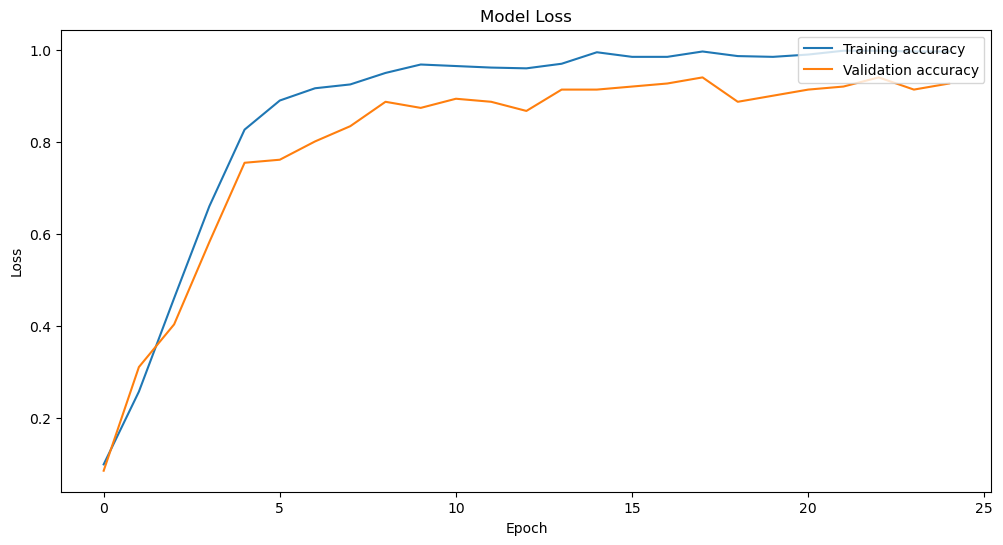

In [318]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('TL-Loss-3-modalities.jpg')
plt.show()

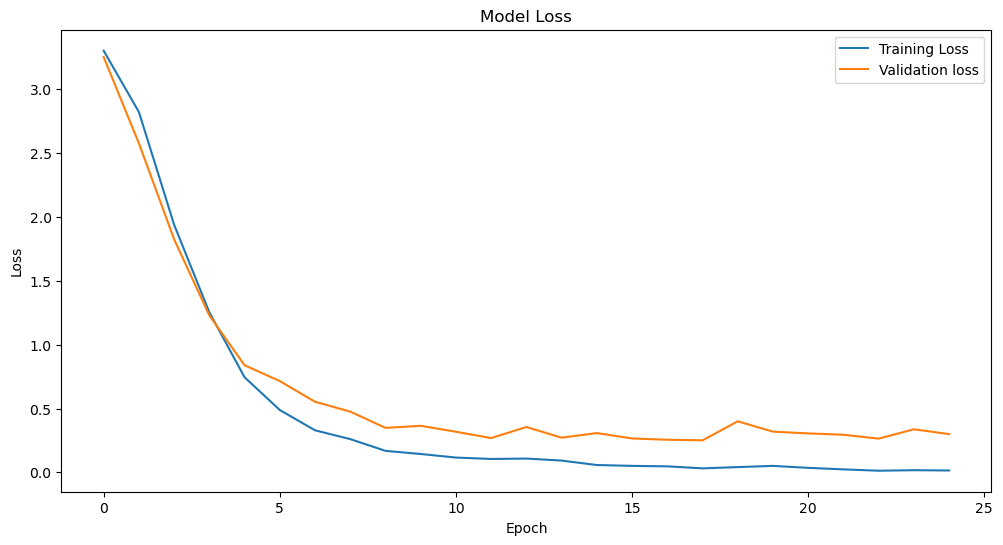

In [319]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('TL-Loss-3-modalities1.jpg')
plt.show()

In [322]:
#model.save('test_541_22act_trainedModel.keras')

In [324]:
del df
del data
del X_features
del y_train

# **Loading the Trained Model to Test over Test data**

In [150]:
model = tf.keras.models.load_model('test_541_22act_trainedModel.keras')

ValueError: File not found: filepath=test_541_22act_trainedModel.keras. Please ensure the file is an accessible `.keras` zip file.

In [328]:
# Path to your test JSON file
test_json_file_path = "D:/test_data.json"  # Update path accordingly

# Load test data
with open(test_json_file_path, 'r') as json_file:
    test_data = json.load(json_file)

# Convert test data to DataFrame
import pandas as pd
df_test = pd.DataFrame(test_data)

# Extract features
X_test_features = [np.array(df_test[column].to_list()) for column in df_test.columns[:-1]]  # Assuming last column is Y_test

# Extract ground truth labels (if available)
y_test = np.array(df_test['Y_test'])  # Update based on your actual test label column

In [330]:
df_test.head()

,GlassAccelerometer_train,GlassGyroscope_train,GlassMagnetometer_train,PhoneAccelerometer_train,PhoneGyroscope_train,PhoneMagnetometer_train,WatchAccelerometer_train,WatchGyroscope_train,WatchMagnetometer_train,Y_test
0,"[1813.0, 1788.0, 1834.0, 1800.0, 1842.0, 1803....","[65400.0, 39.0, 19.0, 117.0, 100.0, 117.0, 84....","[85.0, 72.0, 78.0, 79.0, 84.0, 79.0, 90.0, 84....","[-3.545921, -3.5267668, -3.512401, -3.510007, ...","[-0.0030543264, -0.002443461, -0.0030543264, -...","[141.42, 141.42, 141.48, 141.9, 142.08, 141.95...","[9.083601, 9.126697, 9.176975, 9.14585, 9.1362...","[-0.035430185, -0.037873644, -0.035430185, -0....","[251.09999, 250.92, 250.73999, 251.22, 250.2, ...",12
1,"[3997.0, 3991.0, 4008.0, 4028.0, 4027.0, 3986....","[65377.0, 65372.0, 82.0, 65470.0, 244.0, 65341...","[65387.0, 65393.0, 65393.0, 65386.0, 65383.0, ...","[-2.430189, -2.439766, -2.4421604, -2.4469488,...","[0.005497787, 0.004886922, 0.0018325957, 0.001...","[99.72, 99.9, 99.9, 99.479996, 99.42, 99.42, 9...","[-9.586384, -9.629479, -9.603143, -9.615114, -...","[-0.02076942, -0.014660766, -0.0061086523, 0.0...","[95.1, 95.1, 94.68, 94.56, 94.74, 95.579994, 9...",24
2,"[4039.0, 4004.0, 4028.0, 4044.0, 4022.0, 2776....","[65443.0, 10.0, 65459.0, 65376.0, 195.0, 64967...","[65350.0, 65354.0, 65357.0, 65356.0, 65356.0, ...","[-2.2362528, -2.2314641, -2.2194927, -2.217098...","[0.008552114, 0.009162979, 0.01038471, 0.01221...","[139.37999, 138.95999, 138.9, 139.02, 139.14, ...","[-5.363012, -5.4061074, -5.415684, -5.341464, ...","[-0.015882496, -0.02321288, -0.021991149, -0.0...","[125.939995, 126.06, 125.82, 125.7, 125.759995...",21
3,"[4039.0, 4036.0, 4089.0, 4023.0, 3915.0, 2466....","[65356.0, 65412.0, 36.0, 65428.0, 64990.0, 310...","[65388.0, 65392.0, 65393.0, 65388.0, 65383.0, ...","[-0.9481328, -0.9529214, -0.9601042, -0.976864...","[-0.005497787, -0.005497787, -0.004886922, -0....","[147.42, 147.18, 147.12, 147.0, 147.23999, 147...","[-7.5920134, -7.620744, -7.615956, -7.642292, ...","[-0.013439035, -0.012217305, -0.012217305, -0....","[253.08, 252.29999, 252.54, 251.87999, 252.239...",21
4,"[3413.0, 3409.0, 3419.0, 3398.0, 3386.0, 3464....","[65420.0, 201.0, 65253.0, 65215.0, 65520.0, 65...","[65349.0, 65346.0, 65349.0, 65346.0, 65345.0, ...","[2.4349775, 2.4421604, 2.439766, 2.430189, 2.4...","[-0.009162979, -0.0073303827, -0.008552114, -0...","[73.619995, 74.58, 74.88, 75.479996, 75.06, 74...","[2.0111294, 1.9081788, 1.8076223, 1.9033904, 2...","[0.03176499, -0.02687807, -0.096516706, -0.118...","[45.48, 46.02, 45.899998, 45.78, 45.42, 45.18,...",27


In [332]:
# Get model predictions
y_pred_probs = model.predict(X_test_features)

# Convert softmax probabilities to class predictions
predicted_classes = np.argmax(y_pred_probs, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step


In [334]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_test, predicted_classes, average='macro')
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_test, predicted_classes, average='macro')
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_test, predicted_classes, average='macro')
print(f'F1-Score: {f1}')

Confusion Matrix:
[[ 2  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  1  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 

In [336]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Test Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

Test Accuracy: 0.91
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        12
           2       0.75      0.75      0.75         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         1
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       1.00      0.70      0.82        10
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         5
          10       0.94      1.00      0.97        15
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         5
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         5
       

In [338]:
sample_index = 0  # Change this to test other samples

# Extract a single test sample
X_sample = [feature[sample_index:sample_index+1] for feature in X_test_features]

# Predict
sample_pred_probs = model.predict(X_sample)
sample_pred = np.argmax(sample_pred_probs, axis=1)

print(f"Predicted class: {sample_pred[0]}")
print(f"Actual Class: {y_test[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Predicted class: 12
Actual Class: 12
